\newpage

In [1036]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import neighbors
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score
import statsmodels.api as sm
from ucimlrepo import fetch_ucirepo
import pysubgroup as ps
from mlxtend.feature_selection import ExhaustiveFeatureSelector as EFS

## Questions

### 1. Classification Problem Identification

The chronic kidney disease (CKD) dataset presents a range of variables for many individuals, along with whether they have CKD or not. In this case, the goal is to effectively classify a new individual as either having CKD or not, based on their set of variables.

In [1037]:
CKD = fetch_ucirepo(id=336) 

X = CKD.data.features 
y = CKD.data.targets

df = CKD.data.original

### 2. Variable Transformation

For this dataset, standardization is done *prior* to the classification algorithm (so that the exploratory analysis is based on the actual datasets). Standardizing predictor variables is crucial for KNN and logistic classification in particular because the algorithms work based on distance, and if some variables are on a larger scale, the distances are unfairly more pronounced. By standardizing, all predictors are on the same scale and can fairly be judged by distance.

### 3. Dataset Overview

As shown below, there are 24 features/variables and 400 observations. Furthermore, all variables are either type `float` or `object`. Among the variables that are type `float`, the summary statistics and distributions are shown below. The ages of individuals in this dataset range from 2 to 90 years, with a mean age of 51 years.

In [1038]:
X.shape

(400, 24)

In [1039]:
df.dtypes

age      float64
bp       float64
sg       float64
al       float64
su       float64
rbc       object
pc        object
pcc       object
ba        object
bgr      float64
bu       float64
sc       float64
sod      float64
pot      float64
hemo     float64
pcv      float64
wbcc     float64
rbcc     float64
htn       object
dm        object
cad       object
appet     object
pe        object
ane       object
class     object
dtype: object

In [1040]:
df.describe()

,age,bp,sg,al,su,bgr,bu,sc,sod,pot,hemo,pcv,wbcc,rbcc
count,391.000000,388.000000,353.000000,354.000000,351.000000,356.000000,381.000000,383.000000,313.000000,312.000000,348.000000,329.000000,294.000000,269.000000
mean,51.483376,76.469072,1.017408,1.016949,0.450142,148.036517,57.425722,3.072454,137.528754,4.627244,12.526437,38.884498,8406.122449,4.707435
std,17.169714,13.683637,0.005717,1.352679,1.099191,79.281714,50.503006,5.741126,10.408752,3.193904,2.912587,8.990105,2944.474190,1.025323
min,2.000000,50.000000,1.005000,0.000000,0.000000,22.000000,1.500000,0.400000,4.500000,2.500000,3.100000,9.000000,2200.000000,2.100000
25%,42.000000,70.000000,1.010000,0.000000,0.000000,99.000000,27.000000,0.900000,135.000000,3.800000,10.300000,32.000000,6500.000000,3.900000
50%,55.000000,80.000000,1.020000,0.000000,0.000000,121.000000,42.000000,1.300000,138.000000,4.400000,12.650000,40.000000,8000.000000,4.800000
75%,64.500000,80.000000,1.020000,2.000000,0.000000,163.000000,66.000000,2.800000,142.000000,4.900000,15.000000,45.000000,9800.000000,5.400000
max,90.000000,180.000000,1.025000,5.000000,5.000000,490.000000,391.000000,76.000000,163.000000,47.000000,17.800000,54.000000,26400.000000,8.000000


### 4. Association Between Variables

The correlation heatmap/matrix is shown below, with the binary categorical variables removed.

The strongest correlation with two different variables are with `sc` (serum creatine) and `sod` (sodium), at around $r=-0.69$.

The weakest correaltion with two different variables are with `sc` (serum creatine) and `wbcc` (white blood cell count), at around $r=0.006$.

It is important to consider correaltions, because multicollinearity indicates that certain variables are redundant since they do not communicate new information, which creates non-unique problems during certain algorithms (such as regression). However, in this dataset, no two variables are significantly correlated, and therefore, there is still meaningful variation with each of the feature variables.

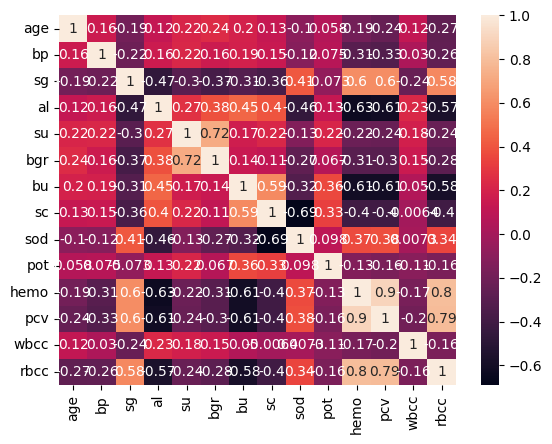

In [1041]:
df_excl = X.drop(['rbc','pc','pcc','ba','htn','dm','cad','appet','pe','ane'],axis=1)
sns.heatmap(df_excl.corr(),annot=True)
plt.show()

### 5. Missing Value Analysis and Handling

After dropping missing values below, the number of observations reduced from 400 to 158. Therefore, there were missing values. The classification techniques cannot handle missingness, and therefore, the rows with `NaN` entries are removed.

In [1042]:
df = df.dropna()
df.shape

(158, 25)

### 6. Outlier Analysis

For the outlier analysis, among the quantitative variables, only the subset within three standard deviations from the mean are kept. This should remove any clear outliers.

In [1043]:
X = df

X = X[(X['age'] < X['age'].mean()+3*X['age'].std()) & (X['age'] > X['age'].mean()-3*X['age'].std())]
X = X[(X['bp'] < X['bp'].mean()+3*X['bp'].std()) & (X['bp'] > X['bp'].mean()-3*X['bp'].std())]
X = X[(X['sg'] < X['sg'].mean()+3*X['sg'].std()) & (X['sg'] > X['sg'].mean()-3*X['sg'].std())]
X = X[(X['al'] < X['al'].mean()+3*X['al'].std()) & (X['al'] > X['al'].mean()-3*X['al'].std())]
X = X[(X['su'] < X['su'].mean()+3*X['su'].std()) & (X['su'] > X['su'].mean()-3*X['su'].std())]
X = X[(X['bgr'] < X['bgr'].mean()+3*X['bgr'].std()) & (X['bgr'] > X['bgr'].mean()-3*X['bgr'].std())]
X = X[(X['bu'] < X['bu'].mean()+3*X['bu'].std()) & (X['bu'] > X['bu'].mean()-3*X['bu'].std())]
X = X[(X['sc'] < X['sc'].mean()+3*X['sc'].std()) & (X['sc'] > X['sc'].mean()-3*X['sc'].std())]
X = X[(X['sod'] < X['sod'].mean()+3*X['sod'].std()) & (X['sod'] > X['sod'].mean()-3*X['sod'].std())]
X = X[(X['pot'] < X['pot'].mean()+3*X['pot'].std()) & (X['pot'] > X['pot'].mean()-3*X['pot'].std())]
X = X[(X['hemo'] < X['hemo'].mean()+3*X['hemo'].std()) & (X['hemo'] > X['hemo'].mean()-3*X['hemo'].std())]
X = X[(X['pcv'] < X['pcv'].mean()+3*X['pcv'].std()) & (X['pcv'] > X['pcv'].mean()-3*X['pcv'].std())]
X = X[(X['wbcc'] < X['wbcc'].mean()+3*X['wbcc'].std()) & (X['wbcc'] > X['wbcc'].mean()-3*X['wbcc'].std())]
X = X[(X['rbcc'] < X['rbcc'].mean()+3*X['rbcc'].std()) & (X['rbcc'] > X['rbcc'].mean()-3*X['rbcc'].std())]

df = X

### 7. Sub-Group Analysis

The subgroup analysis is done below with the help of the `pysubgroup` package. First, the categorical variables are converted to numerical values.

It was found that for the 5 subgroups, these have low rates of CKD. For example, if `hemo` (hemoglobin) is less than 13.60 gms and `pcv` (packed cell volume) is less than 41, there is a 7.2% of having CKD (i.e., out of 100 individuals in this subgroup, about 7 have CKD). As another example, for the subgroup where `bu` (blood urea) is greater or equal to 47 mgs/dl and `hemo` (hemoglobin) is less than 13.6 gms, there is a 6.45% chance of having CKD.

A bar plot is shown below with the five subgroups and there chance of having CKD.


In [1044]:
cat_columns = df.select_dtypes(
    include=['object']
    ).columns

for col in cat_columns:
    df[col] = df[col].astype('category').cat.codes

df['class'] = df['class'].replace([0,1], [1,0])

df.describe()

,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,...,pcv,wbcc,rbcc,htn,dm,cad,appet,pe,ane,class
count,126.00000,126.000000,126.000000,126.000000,126.000000,126.000000,126.000000,126.000000,126.000000,126.000000,...,126.000000,126.000000,126.000000,126.000000,126.000000,126.000000,126.000000,126.000000,126.0,126.000000
mean,47.52381,71.825397,1.021746,0.253968,0.023810,0.952381,0.944444,0.015873,0.031746,113.325397,...,45.428571,7911.904762,5.224603,0.063492,0.055556,0.015873,0.023810,0.023810,0.0,0.087302
std,15.75955,8.980048,0.003759,0.875776,0.153064,0.213809,0.229976,0.125483,0.176023,29.990620,...,5.613453,2154.274157,0.706732,0.244819,0.229976,0.125483,0.153064,0.153064,0.0,0.283403
min,6.00000,60.000000,1.010000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,70.000000,...,28.000000,4300.000000,3.200000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
25%,35.25000,60.000000,1.020000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,95.000000,...,42.000000,6425.000000,4.800000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
50%,47.00000,70.000000,1.020000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,109.000000,...,45.500000,7400.000000,5.200000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
75%,59.00000,80.000000,1.025000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,126.500000,...,50.000000,9375.000000,5.700000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
max,80.00000,90.000000,1.025000,4.000000,1.000000,1.000000,1.000000,1.000000,1.000000,253.000000,...,54.000000,16700.000000,6.500000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,1.000000


In [1045]:
target = ps.BinaryTarget ('class', True)
searchspace = ps.create_selectors(df, ignore=['class'])
task = ps.SubgroupDiscoveryTask (
    df,
    target,
    searchspace,
    result_set_size=5,
    depth=2,
    qf=ps.WRAccQF())
result = ps.DFS().execute(task)
result = result.to_dataframe()
result

,quality,subgroup,size_sg,size_dataset,positives_sg,positives_dataset,size_complement,relative_size_sg,relative_size_complement,coverage_sg,coverage_complement,target_share_sg,target_share_complement,target_share_dataset,lift
0,0.072436,hemo<13.60 AND pcv<41.0,10,126,10,11,116,0.079365,0.920635,0.909091,0.090909,1.000000,0.008621,0.087302,11.454545
1,0.069665,pcv<41.0,14,126,10,11,112,0.111111,0.888889,0.909091,0.090909,0.714286,0.008929,0.087302,8.181818
2,0.069665,ane==0 AND pcv<41.0,14,126,10,11,112,0.111111,0.888889,0.909091,0.090909,0.714286,0.008929,0.087302,8.181818
3,0.065193,pcv<41.0 AND rbcc<4.70,9,126,9,11,117,0.071429,0.928571,0.818182,0.181818,1.000000,0.017094,0.087302,11.454545
4,0.064500,bu>=47.0 AND hemo<13.60,10,126,9,11,116,0.079365,0.920635,0.818182,0.181818,0.900000,0.017241,0.087302,10.309091


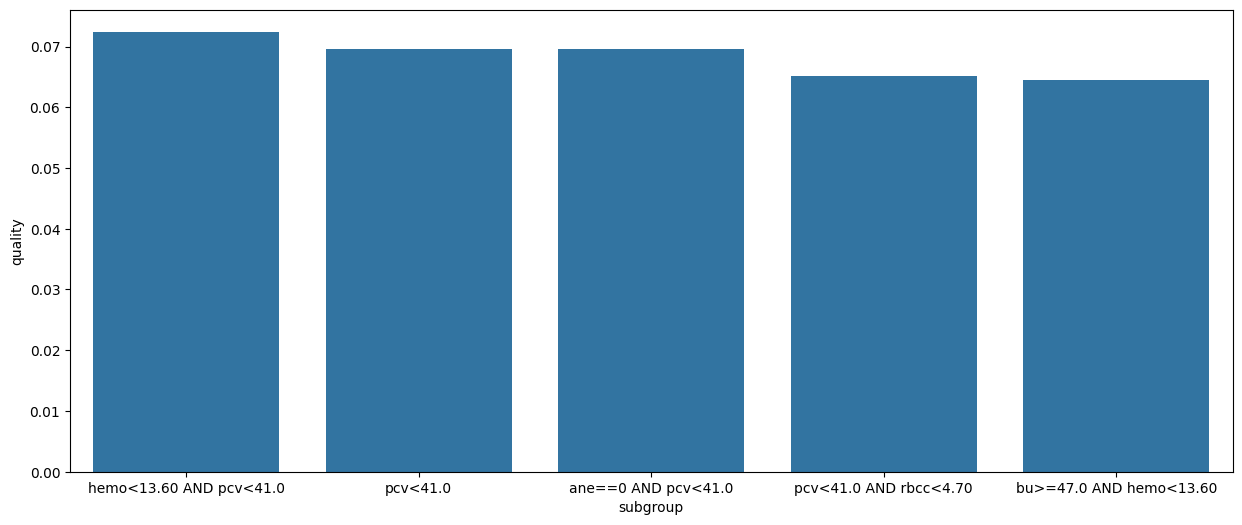

In [1046]:
plt.figure(figsize=(15,6))
sns.barplot(x=result.subgroup,y=result.quality)
plt.show()

### 8. Data Splitting

Before beginning with the classifier algorithms, the dataset is scaled (as explained above). The training and testing sets are assigned below.

In [1047]:
x = df.drop(['class'], axis=1)
y = df['class']
xscale = scale(x, axis=0)
x = pd.DataFrame(xscale, columns = x.columns)

In [1048]:
X_train, X_test, y_train, y_test = train_test_split(
    x, y, test_size=0.3, random_state=0, stratify=y)

### 9. Classifier Choices

The two classifiers that are chosen are **KNN** and **logistic regression**. These were chosen because they both work well with binary classifications (either 1 or 0, that is, either having CKD or not).

### 10. Performance Metrics

The performance metrics that will be used are the **accuracy** (proportion of correct predictions), the **specificity** (rate of true negatives) and **sensitivity** (rate of true positives).

### 11. Feature Selection/Extraction and 12. Classifier Comparison

The codes for KNN and logistic regression are provided above.

To summarize, when using all 24 features, both algorithms have a perfect accuracy, sensitivity, and specificity. When the number of features for logistic regression is reduced to 2 ('al' and 'pcv'), the algorithm still performs perfectly.

**KNN Algorithm**: As shown below, the optimal value is $K=1$ (highest accuracy). From the confusion matrix, the sensitivity and specificity are exactly 1, since there are no false negatives or false positives.

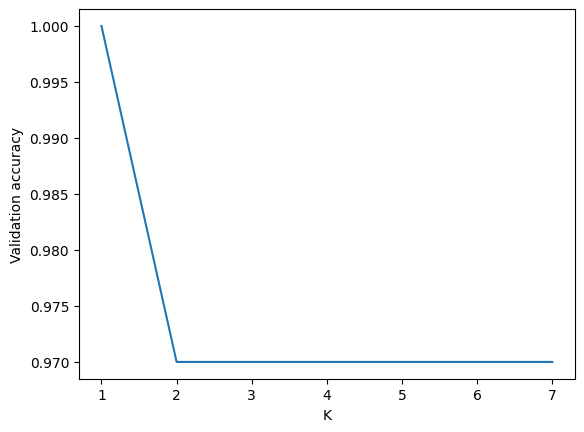

In [1049]:
### KNN Algorithm ###

k_range = range(1, 8)
scores = [] 

for k in k_range:
    knn = neighbors.KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    scores.append(round(metrics.accuracy_score(y_test, y_pred),2))

plt.plot(k_range, scores)
plt.xlabel('K')
plt.ylabel('Validation accuracy')
plt.xticks(range(1,8))
plt.show()

In [1050]:
knn = neighbors.KNeighborsClassifier(n_neighbors = 1)
knn.fit(X_train,y_train)
pred = knn.predict(X_test)

print(round(metrics.accuracy_score(y_test, pred),2))
print(metrics.confusion_matrix(y_test, pred).T)

1.0
[[35  0]
 [ 0  3]]


**Logistic Regression**: The performance metrics are identical, with perfect accuracy, sensitivity, and specificity.

In [1051]:
def_log = LogisticRegression(max_iter=1000)
def_log.fit(X_train, y_train)
pred_prob = def_log.predict_proba(X_test)
df1 = pd.DataFrame(
    data = {'prob1': pred_prob[:,1], 'y_test': y_test}
    )

df1['y_test_pred'] = df1.prob1.map(lambda x: 1 if x>0.5 else 0)

cm = confusion_matrix(df1.y_test, df1.y_test_pred)

total = sum(sum(cm))

accuracy = (cm[0,0]+cm[1,1])/total
print ('Accuracy : ', accuracy)

sensitivity = cm[1,1]/(cm[1,0]+cm[1,1]) 
print('Sensitivity : ', sensitivity )

specificity = cm[0,0]/(cm[0,0]+cm[0,1])
print('Specificity : ', specificity)

print('Confusion Matrix : \n', cm)


Accuracy :  1.0
Sensitivity :  1.0
Specificity :  1.0
Confusion Matrix : 
 [[35  0]
 [ 0  3]]


Feature selection/extraction is implemented for the logistic regression, as shown below. Instead of using all 24 features, we can still achieve a perfect accuracy by using 'al' (albumin) and 'pcv' (packed cell volume) only. When implemented, the accuracy, sensitivity, and specificity are all perfect.

In [1052]:
efs = EFS(estimator=def_log, min_features=1, max_features=4, scoring='accuracy', cv=5)                

efs = efs.fit(X_train, y_train)

print('Best accuracy score: %.2f' % efs.best_score_)
print('Best subset (indices):', efs.best_idx_)
print('Best subset (corresponding names):', efs.best_feature_names_)


Features: 12950/12950

Best accuracy score: 1.00
Best subset (indices): (3, 15)
Best subset (corresponding names): ('al', 'pcv')


In [1053]:
X_train_new = X_train[['al','pcv']]
X_test_new = X_test[['al','pcv']]

def_log.fit(X_train_new, y_train)
pred_prob = def_log.predict_proba(X_test_new)
df1 = pd.DataFrame(
    data = {'prob1': pred_prob[:,1], 'y_test': y_test}
    )

df1['y_test_pred'] = df1.prob1.map(lambda x: 1 if x>0.5 else 0)

cm = confusion_matrix(df1.y_test, df1.y_test_pred)

total = sum(sum(cm))

accuracy = (cm[0,0]+cm[1,1])/total
print ('Accuracy : ', accuracy)

sensitivity = cm[1,1]/(cm[1,0]+cm[1,1]) 
print('Sensitivity : ', sensitivity )

specificity = cm[0,0]/(cm[0,0]+cm[0,1])
print('Specificity : ', specificity)

print('Confusion Matrix : \n', cm)

Accuracy :  1.0
Sensitivity :  1.0
Specificity :  1.0
Confusion Matrix : 
 [[35  0]
 [ 0  3]]


### 13. Interpretable Classifier Insight

For this question, the original dataset is used, except with missing values removed. Interestingly, even when including outliers, logistic regression still performs perfectly in terms of accuracy, sensitivity, and specificity.

The plot below shows the significance of each of the features. The most important feature in predicting CKD is by far the level of albumin ('al'). The least important feature is the level of potassium ('pot').

In [1054]:
df = CKD.data.original
df = df.dropna()

cat_columns = df.select_dtypes(
    include=['object']
    ).columns

for col in cat_columns:
    df[col] = df[col].astype('category').cat.codes

df['class'] = df['class'].replace([0,2], [0,1])

df.describe()

,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,...,pcv,wbcc,rbcc,htn,dm,cad,appet,pe,ane,class
count,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,...,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000
mean,49.563291,74.050633,1.019873,0.797468,0.253165,0.886076,0.816456,0.088608,0.075949,131.341772,...,41.917722,8475.949367,4.891772,0.215190,0.177215,0.069620,0.120253,0.126582,0.101266,0.727848
std,15.512244,11.175381,0.005499,1.413130,0.813397,0.318729,0.388343,0.285080,0.265759,64.939832,...,9.105164,3126.880181,1.019364,0.412261,0.383065,0.255315,0.326292,0.333562,0.302640,0.446483
min,6.000000,50.000000,1.005000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,70.000000,...,9.000000,3800.000000,2.100000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,39.250000,60.000000,1.020000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,97.000000,...,37.500000,6525.000000,4.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,50.500000,80.000000,1.020000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,115.500000,...,44.000000,7800.000000,4.950000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,60.000000,80.000000,1.025000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,131.750000,...,48.000000,9775.000000,5.600000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,83.000000,110.000000,1.025000,4.000000,5.000000,1.000000,1.000000,1.000000,1.000000,490.000000,...,54.000000,26400.000000,8.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [1055]:
x = df.drop(['class'], axis=1)
y = df['class']
xscale = scale(x, axis=0)
x = pd.DataFrame(xscale, columns = x.columns)

X_train, X_test, y_train, y_test = train_test_split(
    x, y, test_size=0.3, random_state=0, stratify=y)

def_log = LogisticRegression(max_iter=1000)
def_log.fit(X_train, y_train)
pred_prob = def_log.predict_proba(X_test)
df1 = pd.DataFrame(
    data = {'prob1': pred_prob[:,1], 'y_test': y_test}
    )

df1['y_test_pred'] = df1.prob1.map(lambda x: 1 if x>0.5 else 0)

cm = confusion_matrix(df1.y_test, df1.y_test_pred)

total = sum(sum(cm))

accuracy = (cm[0,0]+cm[1,1])/total
print ('Accuracy : ', accuracy)

sensitivity = cm[1,1]/(cm[1,0]+cm[1,1]) 
print('Sensitivity : ', sensitivity )

specificity = cm[0,0]/(cm[0,0]+cm[0,1])
print('Specificity : ', specificity)

print('Confusion Matrix : \n', cm)

Accuracy :  1.0
Sensitivity :  1.0
Specificity :  1.0
Confusion Matrix : 
 [[13  0]
 [ 0 35]]


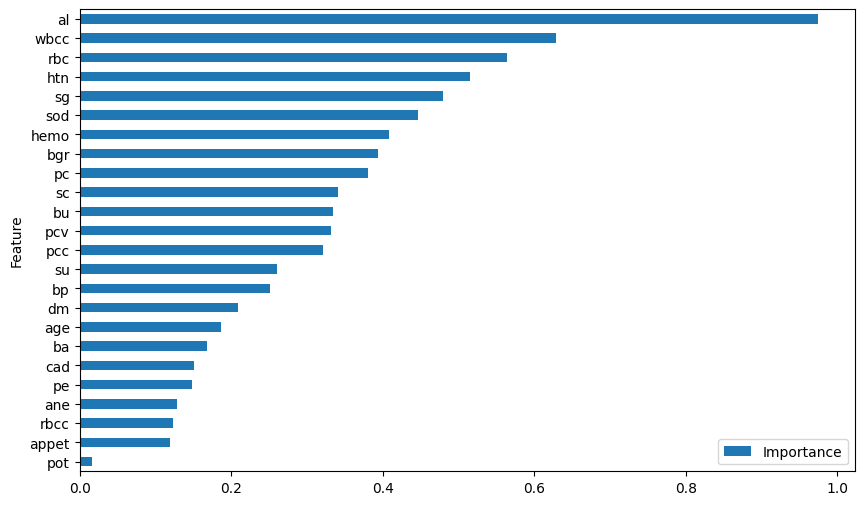

In [1056]:

coefficients = def_log.coef_[0]

feature_importance = pd.DataFrame({'Feature': x.columns, 'Importance': np.abs(coefficients)})
feature_importance = feature_importance.sort_values('Importance', ascending=True)
feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6))
plt.show()

Note: Questions 14 (Bonus) is not attempted. Further, Question 15 does not apply since the assignment was completed individually.

### 16. Link

The GitHub link is: https://github.com/RiyadhBaksh/STATS3DA3.git